In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
from skimage.io import imread, imshow
import shutil
import os

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.layers import Conv2D, MaxPool2D, UpSampling2D, Input, LeakyReLU
from keras.models import Sequential, load_model

In [2]:
TRAIN_DIR = '/content/drive/MyDrive/DATASCIENCE/musemart/dataset_updated/training_set'
DEST = '/content/drive/MyDrive/DATASCIENCE/dataset/train/images'

if not os.path.exists(DEST):
  os.makedirs(DEST)

for dir in os.listdir(TRAIN_DIR):
  for img in os.listdir(os.path.join(TRAIN_DIR,dir)):
    ORG = os.path.join(TRAIN_DIR,dir,img)
    try:
      imread(ORG)
      shutil.copy(ORG,DEST)
    except:
      print(f"The image at {ORG} cannot be read.")  

The image at /content/drive/MyDrive/DATASCIENCE/musemart/dataset_updated/training_set/painting/1050.jpg cannot be read.
The image at /content/drive/MyDrive/DATASCIENCE/musemart/dataset_updated/training_set/painting/1850.jpg cannot be read.
The image at /content/drive/MyDrive/DATASCIENCE/musemart/dataset_updated/training_set/painting/1425.jpg cannot be read.
The image at /content/drive/MyDrive/DATASCIENCE/musemart/dataset_updated/training_set/painting/0825.jpg cannot be read.
The image at /content/drive/MyDrive/DATASCIENCE/musemart/dataset_updated/training_set/painting/1175.jpg cannot be read.
The image at /content/drive/MyDrive/DATASCIENCE/musemart/dataset_updated/training_set/painting/1275.jpg cannot be read.
The image at /content/drive/MyDrive/DATASCIENCE/musemart/dataset_updated/training_set/painting/0675.jpg cannot be read.
The image at /content/drive/MyDrive/DATASCIENCE/musemart/dataset_updated/training_set/painting/1825.jpg cannot be read.
The image at /content/drive/MyDrive/DATA

In [3]:
#---Total number of images in training dataset
len(os.listdir('/content/drive/MyDrive/DATASCIENCE/dataset/train/images'))

3263

In [4]:
#Applying Data Augmentation: Flipping and Rotation
train_datagen = ImageDataGenerator(rescale=1/255,
                                   featurewise_center=True,
                                   rotation_range=40,
                                   horizontal_flip=True,
                                   vertical_flip=True)

In [7]:
train = train_datagen.flow_from_directory('/content/drive/MyDrive/DATASCIENCE/dataset/train',
                                          target_size=(256,256),
                                          batch_size=1500,
                                          shuffle=True)

Found 3263 images belonging to 1 classes.


In [8]:
#Visualization of images
t_img, label = train.next()

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [9]:
def plotImg(img_arr,label):
  plt.figure(figsize=(5,5))
  for im,l in zip(img_arr,label):
    plt.imshow(im)
    plt.title(l)
    plt.axis('off')
    plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


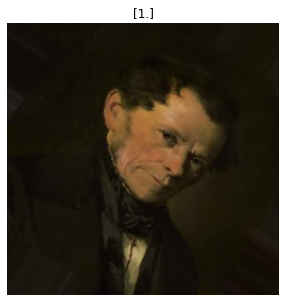

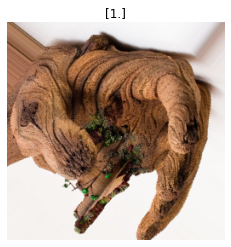

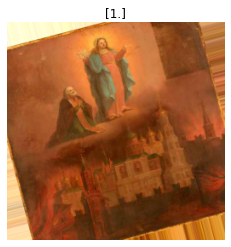

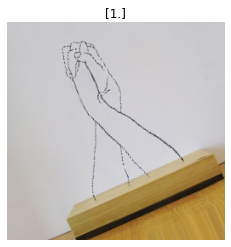

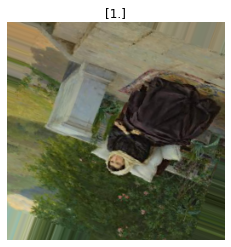

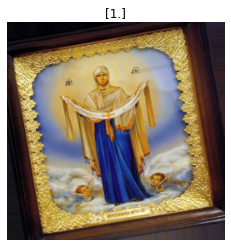

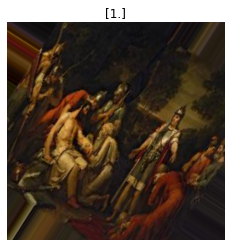

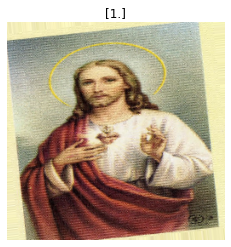

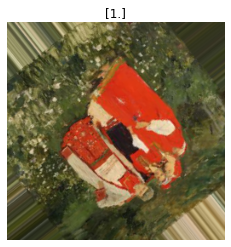

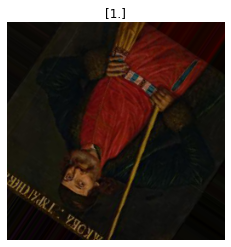

In [10]:
plotImg(t_img[:10],label[:10])

### 4. Preparing training dataset

Testing dataset is not required

In [12]:
#Convert rgb image into lab
X=[]
Y=[]

In [13]:
for img in t_img:
  try:
    lab=rgb2lab(img)
    X.append(lab[:,:,0])
    Y.append(lab[:,:,1:]/128)
  except:
    print("Error")

In [14]:
X_train = np.array(X)
X_train = np.expand_dims(X_train, axis=len(X_train.shape))

Y_train = np.array(Y)

X_train.shape, Y_train.shape

((1500, 256, 256, 1), (1500, 256, 256, 2))

### 5. Building the Autoencoder Model

In [15]:
#Building the model

#Encoder
model = Sequential()
model.add(Conv2D(64,(3,3), activation= 'relu', padding ='same',strides = 2, input_shape = (256,256,1)))
model.add(Conv2D(128,(3,3), activation= 'relu', padding ='same'))
model.add(Conv2D(128,(3,3), activation= 'relu', padding ='same',strides = 2))
model.add(Conv2D(256,(3,3), activation= 'relu', padding ='same'))
model.add(Conv2D(256,(3,3), activation= 'relu', padding ='same',strides = 2))
model.add(Conv2D(512,(3,3), activation= 'relu', padding ='same'))
model.add(Conv2D(512,(3,3), activation= 'relu', padding ='same'))
model.add(Conv2D(256,(3,3), activation= 'relu', padding ='same'))

#Decoder
model.add(Conv2D(128,(3,3), activation = 'relu', padding = 'same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(64,(3,3), activation = 'relu', padding = 'same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(32,(3,3), activation = 'relu', padding = 'same'))
model.add(Conv2D(16,(3,3), activation = 'relu', padding = 'same'))
model.add(Conv2D(2,(3,3), activation = LeakyReLU(alpha=0.01), padding = 'same'))
model.add(UpSampling2D((2,2)))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 256)       295168    
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 256)       590080    
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 512)       1180160   
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 512)       2

In [16]:
model.compile(optimizer='adam', metrics=['acc'], loss='mse')

In [17]:
his = model.fit(X_train, Y_train, epochs=40, batch_size=32, steps_per_epoch=X_train.shape[0]//32, verbose=1)

Epoch 1/40
46/46 [==============================] - 71s 622ms/step - loss: 1.5012 - acc: 0.3182
Epoch 2/40
46/46 [==============================] - 39s 623ms/step - loss: 0.0098 - acc: 0.6207
Epoch 3/40
46/46 [==============================] - 29s 622ms/step - loss: 0.0079 - acc: 0.8184
Epoch 4/40
46/46 [==============================] - 29s 622ms/step - loss: 0.0077 - acc: 0.8267
Epoch 5/40
46/46 [==============================] - 29s 622ms/step - loss: 0.0076 - acc: 0.8250
Epoch 6/40
46/46 [==============================] - 29s 624ms/step - loss: 0.0074 - acc: 0.8263
Epoch 7/40
46/46 [==============================] - 29s 625ms/step - loss: 0.0072 - acc: 0.8263
Epoch 8/40
46/46 [==============================] - 29s 624ms/step - loss: 0.0071 - acc: 0.8288
Epoch 9/40
46/46 [==============================] - 29s 625ms/step - loss: 0.0070 - acc: 0.8281
Epoch 10/40
46/46 [==============================] - 29s 624ms/step - loss: 0.0070 - acc: 0.8317
Epoch 11/40
46/46 [====================

In [18]:
model.save("/content/drive/MyDrive/DATASCIENCE/bestmodel.h5")

### 6. Plotting Graphs

In [21]:
model = load_model('/content/drive/MyDrive/DATASCIENCE/bestmodel.h5')

acc = his.history['acc']
loss = his.history['loss']

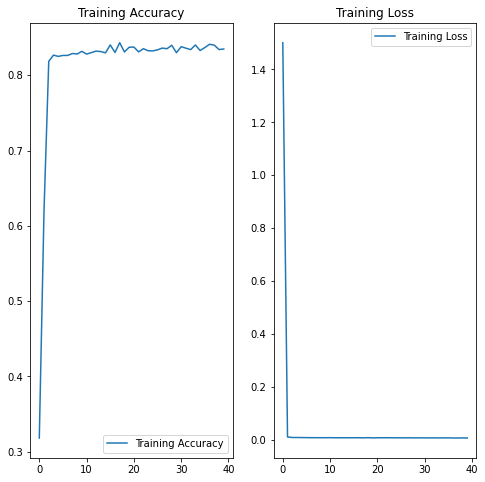

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(40), acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(40), loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

### 7. Coloring the B/W input image

In [23]:
def colorize(path):
  imshow(path)
  img1_color=[]
  img = img_to_array(
      load_img(path,target_size=(256,256,3))    
  )/255
  img1_color.append(img)
  img1_color = rgb2lab(img1_color)[:,:,:,0]
  img1_color = img1_color.reshape(img1_color.shape+(1,))
  output1 = model.predict(img1_color)
  output1=output1*128

  result = np.zeros((256,256,3))
  result[:,:,0] = img1_color[0][:,:,0]
  result[:,:,1:] = output1[0]

  img=lab2rgb(result)
  imshow(img)

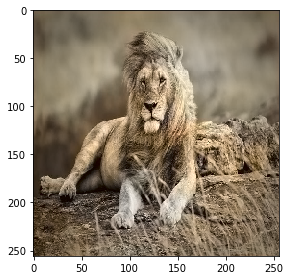

In [27]:
colorize("/content/tiger.jfif")